# Sarter Notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Reading Data

In [2]:
# read train data
df_orders = pd.read_csv("orders.csv", sep=";")
df_products = pd.read_csv("product_attributes.csv", sep=",")
df_dists = pd.read_csv("cities_data.csv", sep=";")

# read test data
df_test = pd.read_csv("test.csv", sep=";")

# Clean the data

In [60]:
df_orders["origin_port"] = df_orders["origin_port"].replace(["ATHENAS"], "Athens")
df_orders["origin_port"] = df_orders["origin_port"].replace(["BCN"], "Barcelona")
df_orders["late_order"] = df_orders["late_order"].astype(int)

# Analaize the data

In [61]:
df_orders.head()


,order_id,origin_port,3pl,customs_procedures,logistic_hub,customer,product_id,units,late_order
0,366c7a3d298f,Rotterdam,v_002,DTP,Venlo,Marseille,1692723,583,1
1,45f906331e10,Rotterdam,v_004,CRF,Rome,Marseille,1644308,459,0
2,ac84a6e4af0f,Athens,v_002,CRF,Venlo,Paris,1684170,464,1
3,f5e98cb29790,Rotterdam,v_004,CRF,Lille,Milan,1620510,678,0
4,a9e7c9bee35b,Barcelona,v_002,CRF,Venlo,Berlin,1699372,353,0


In [62]:
counts1 = df_orders["late_order"].groupby(df_orders["3pl"]).value_counts()
# For every 3pl, print the percentage of late orders
for i in range(1, 5):
    print(f"v_00{i}", ":", counts1[f"v_00{i}"][0]/(counts1[f"v_00{i}"][0]+counts1[f"v_00{i}"][1]))

v_001 : 0.6179014667168108
v_002 : 0.8005533611227406
v_003 : 0.7497475840184624
v_004 : 0.7430507101217673


In [63]:
counts2 = df_orders["late_order"].groupby(df_orders["customs_procedures"]).value_counts()
print(counts2)
# For every custom_procedures, print the percentage of late orders
for name in ["CRF", "DTD", "DTP"]:
   print(name, ":", counts2[name][0]/(counts2[name][0]+counts2[name][1]))

customs_procedures  late_order
CRF                 0             41274
                    1             10203
DTD                 0             32548
                    1             10936
DTP                 0             13298
                    1              6017
Name: late_order, dtype: int64
CRF : 0.801794976397226
DTD : 0.7485051973139546
DTP : 0.6884804556044525


In [64]:
counts3 = df_orders["customs_procedures"].groupby(df_orders["3pl"]).value_counts()
print(counts3)

3pl    customs_procedures
v_001  CRF                    3686
       DTD                    2960
       DTP                    1331
v_002  CRF                   24595
       DTD                   21035
       DTP                    9307
v_003  CRF                    3103
       DTD                    2658
       DTP                    1172
v_004  CRF                   20093
       DTD                   16831
       DTP                    7505
Name: customs_procedures, dtype: int64


In [ ]:
df_orders.describe()

# ML

### Split the data

In [167]:
import sklearn as sk
X = df_orders.drop(['late_order', 'order_id', 'product_id', 'units'], axis=1)
y = np.array(df_orders['late_order'])

X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
print(y_test)

       origin_port    3pl customs_procedures logistic_hub   customer
0        Rotterdam  v_002                DTP        Venlo  Marseille
1        Rotterdam  v_004                CRF         Rome  Marseille
2           Athens  v_002                CRF        Venlo      Paris
3        Rotterdam  v_004                CRF        Lille      Milan
4        Barcelona  v_002                CRF        Venlo     Berlin
...            ...    ...                ...          ...        ...
114271   Rotterdam  v_002                CRF   Dusseldorf   Bordeaux
114272   Barcelona  v_004                DTD   Dusseldorf     Berlin
114273   Rotterdam  v_002                DTP   Dusseldorf       Rome
114274   Barcelona  v_003                DTD   Dusseldorf     Munich
114275   Rotterdam  v_002                DTD        Venlo  Bucharest

[114276 rows x 5 columns]
[1 0 0 ... 0 0 0]


### SVM

In [170]:
import sklearn.preprocessing as skp

enc = skp.OneHotEncoder(handle_unknown='ignore')
print(X_train)
X_train_enc = enc.fit_transform(X_train)
X_test_enc = enc.transform(X_test)
print(X_train_enc[17])



       origin_port    3pl customs_procedures logistic_hub   customer
70095    Rotterdam  v_002                DTP      Hamburg       Lyon
102218      Athens  v_002                CRF        Lille     Munich
21680    Rotterdam  v_004                DTP   Dusseldorf     Berlin
78998       Athens  v_002                CRF        Liege     Athens
106262   Rotterdam  v_004                CRF       Warsaw     Munich
...            ...    ...                ...          ...        ...
76820    Rotterdam  v_002                CRF        Venlo     Vienna
110268      Athens  v_002                DTD     Zaragoza    Cologne
103694      Athens  v_004                CRF     Zaragoza   Budapest
860      Rotterdam  v_002                CRF        Venlo  Stockholm
15795    Rotterdam  v_002                DTD       Warsaw    Cologne

[91420 rows x 5 columns]
  (0, 1)	1.0
  (0, 4)	1.0
  (0, 8)	1.0
  (0, 15)	1.0
  (0, 37)	1.0


In [200]:
X_train_enc = pd.get_dummies(X_train)
X_test_enc = pd.get_dummies(X_test)
print(X_train_enc.iloc(0)[2])

origin_port_Athens         0
origin_port_Barcelona      0
origin_port_Rotterdam      1
3pl_v_001                  0
3pl_v_002                  0
3pl_v_003                  0
3pl_v_004                  1
customs_procedures_CRF     0
customs_procedures_DTD     0
customs_procedures_DTP     1
logistic_hub_Bratislava    0
logistic_hub_Dusseldorf    1
logistic_hub_Hamburg       0
logistic_hub_Liege         0
logistic_hub_Lille         0
logistic_hub_Rome          0
logistic_hub_Venlo         0
logistic_hub_Warsaw        0
logistic_hub_Zaragoza      0
customer_Amsterdam         0
customer_Athens            0
customer_Barcelona         0
customer_Berlin            1
customer_Bordeaux          0
customer_Bremen            0
customer_Bucharest         0
customer_Budapest          0
customer_Cologne           0
customer_Copenhagen        0
customer_Hanover           0
customer_Helsinki          0
customer_Lisbon            0
customer_Lyon              0
customer_Madrid            0
customer_Malmö

In [189]:
from sklearn.kernel_approximation import Nystroem
import sklearn.svm as svm
feature_map_nystroem = Nystroem(gamma=.2,
                                random_state=43,
                                 n_components=X_train_enc.shape[0])
linmodel = svm.LinearSVC()
linmodel.fit(X_train_enc, y_train)
y_pred = linmodel.predict(X_test_enc)
accuracy = sk.metrics.accuracy_score(y_test, y_pred)

In [190]:

print(accuracy)

0.7736699334966748


### Decision trees

[Text(0.5, 0.875, 'X[2] <= 0.5\nentropy = 0.793\nsamples = 91420\nvalue = [69605, 21815]'),
 Text(0.25, 0.625, 'X[1] <= 0.5\nentropy = 0.915\nsamples = 39197\nvalue = [26275, 12922]'),
 Text(0.125, 0.375, 'X[14] <= 0.5\nentropy = 0.956\nsamples = 21953\nvalue = [13687, 8266]'),
 Text(0.0625, 0.125, 'entropy = 0.941\nsamples = 19977\nvalue = [12836, 7141]'),
 Text(0.1875, 0.125, 'entropy = 0.986\nsamples = 1976\nvalue = [851, 1125]'),
 Text(0.375, 0.375, 'X[4] <= 0.5\nentropy = 0.841\nsamples = 17244\nvalue = [12588, 4656]'),
 Text(0.3125, 0.125, 'entropy = 0.897\nsamples = 8942\nvalue = [6142, 2800]'),
 Text(0.4375, 0.125, 'entropy = 0.767\nsamples = 8302\nvalue = [6446, 1856]'),
 Text(0.75, 0.625, 'X[18] <= 0.5\nentropy = 0.658\nsamples = 52223\nvalue = [43330, 8893]'),
 Text(0.625, 0.375, 'X[14] <= 0.5\nentropy = 0.637\nsamples = 48680\nvalue = [40844, 7836]'),
 Text(0.5625, 0.125, 'entropy = 0.612\nsamples = 44037\nvalue = [37399, 6638]'),
 Text(0.6875, 0.125, 'entropy = 0.824\nsamp

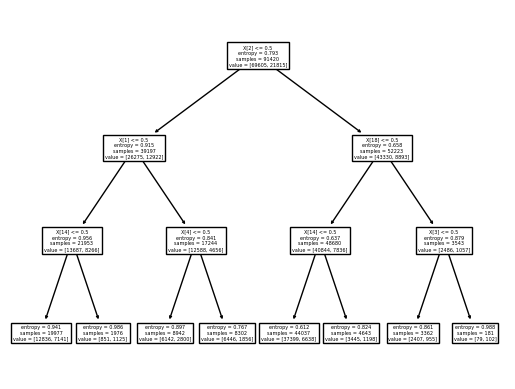

In [201]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

modelt = DecisionTreeClassifier(criterion="entropy", max_depth=3)
modelt.fit(X_train_enc, y_train)
y_pred = modelt.predict(X_test_enc)

plot_tree(modelt)


In [202]:
accuracy2 = sk.metrics.accuracy_score(y_pred, y_test)
print(accuracy2)

0.7688571928596429


## Save Solution
> **Note:** Submited probabilities must be for the **True** cases.

In [ ]:
submission = pd.DataFrame({"order_id": X_test.order_id, "late_order": pred_proba[:,1]})
submission.to_csv("submission_kaggle.csv", index=False)